# Imports

In [1]:
import numpy as np
import cupy as cp
import pyquasar as pq

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format='retina'

In [2]:
air = {"density": 1.21, "speed": 1, "impedance": 415}

In [3]:
f = 1

In [4]:
def u(t, p, n):
    # return t
    return np.zeros_like(p[..., 0])


def source(t, p, n):
    omega = 2 * np.pi * f
    return air["density"] * np.sin(omega * t) / (0.0025)
    return np.zeros_like(p[..., 0])

In [5]:
device = "cuda"

In [6]:
mesh = pq.Mesh.load("cube.geo", refine_k=4)
domains = [pq.FemDomain(domain, device=device) for domain in mesh]

In [7]:
mesh

<Mesh object summary 
	Numeration: global
	Domains: [<MeshDomain object summary
	Material: air
	Total elements number: 4349952
	Element type: Tetrahedron 4; Count: 4349952
	Boundary type: source; Tag: 7; Element type: Triangle 3; Count: 16896.
	Boundary type: dirichlet; Tag: 8; Element type: Triangle 3; Count: 12800.
	Boundary type: dirichlet; Tag: 9; Element type: Triangle 3; Count: 16384.
	Boundary type: dirichlet; Tag: 10; Element type: Triangle 3; Count: 8704.
	Boundary type: dirichlet; Tag: 11; Element type: Triangle 3; Count: 16384.
	Boundary type: dirichlet; Tag: 12; Element type: Triangle 3; Count: 8704.
	Boundary type: dirichlet; Tag: 13; Element type: Triangle 3; Count: 12800.
>]>

In [8]:
time_mesh = pq.TimeMesh(1 / (air["speed"] ** 2), 0.0, 5, 201, 1.00)

In [9]:
problem = pq.HyperbolicProblem(domains, time_mesh, device=device)

In [10]:
materials = {"air": {"source":{"source": source},"gamma": 1}}
# materials = {"air": {"gamma": 1}}
# problem.assembly()

In [11]:
problem.add_init_conds(["dirichlet"], constant_time_step=False)

In [12]:
pts = np.linspace(1, 2.75, 201)
pts = pts + 1.025
pts = np.concatenate(
    [pts[:, None], np.ones_like(pts)[:, None], 1.025 * np.ones_like(pts)[:, None]],
    axis=1,
)

In [15]:
# proj = problem.tabulate(cp.asarray(pts))

In [14]:
sols = problem.solve(
  u,
  ["dirichlet"],
  materials,
  rtol=1e-10,
  verbose=False,
  # proj=proj,
  consant_step_time=False,
)

min:  0e+00 | max:  0e+00 | mean:  0e+00:  25%|██▌       | 50/199 [07:02<20:59,  8.45s/it]


KeyboardInterrupt: 

In [ ]:
len(sols)

201

In [ ]:
pts = np.array(
  [
    [1.025, 1, 1.025],
    [1.025, 2, 1.025],
    [1.025, 3, 1.025],
    [1.025, 4, 1.025],
    [1.025, 5, 1.025],
  ]
)

In [ ]:
proj = problem.tabulate(cp.asarray(pts))
ps = proj @ np.array(sols).T

100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


In [ ]:
ps[ps != 0] = 20 * np.log10(np.abs(ps[ps != 0]) / 0.00002)

In [ ]:
time_mesh.mesh[150]

3.75

In [ ]:
line = np.linspace(0, 5, 200)
spatial_pts = np.array([1.025 * np.ones_like(line), 1 + line, 1.025 * np.ones_like(line)]).T
spatial_proj = problem.tabulate(cp.asarray(spatial_pts))
spatial_sol = spatial_proj @ sols[150]

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


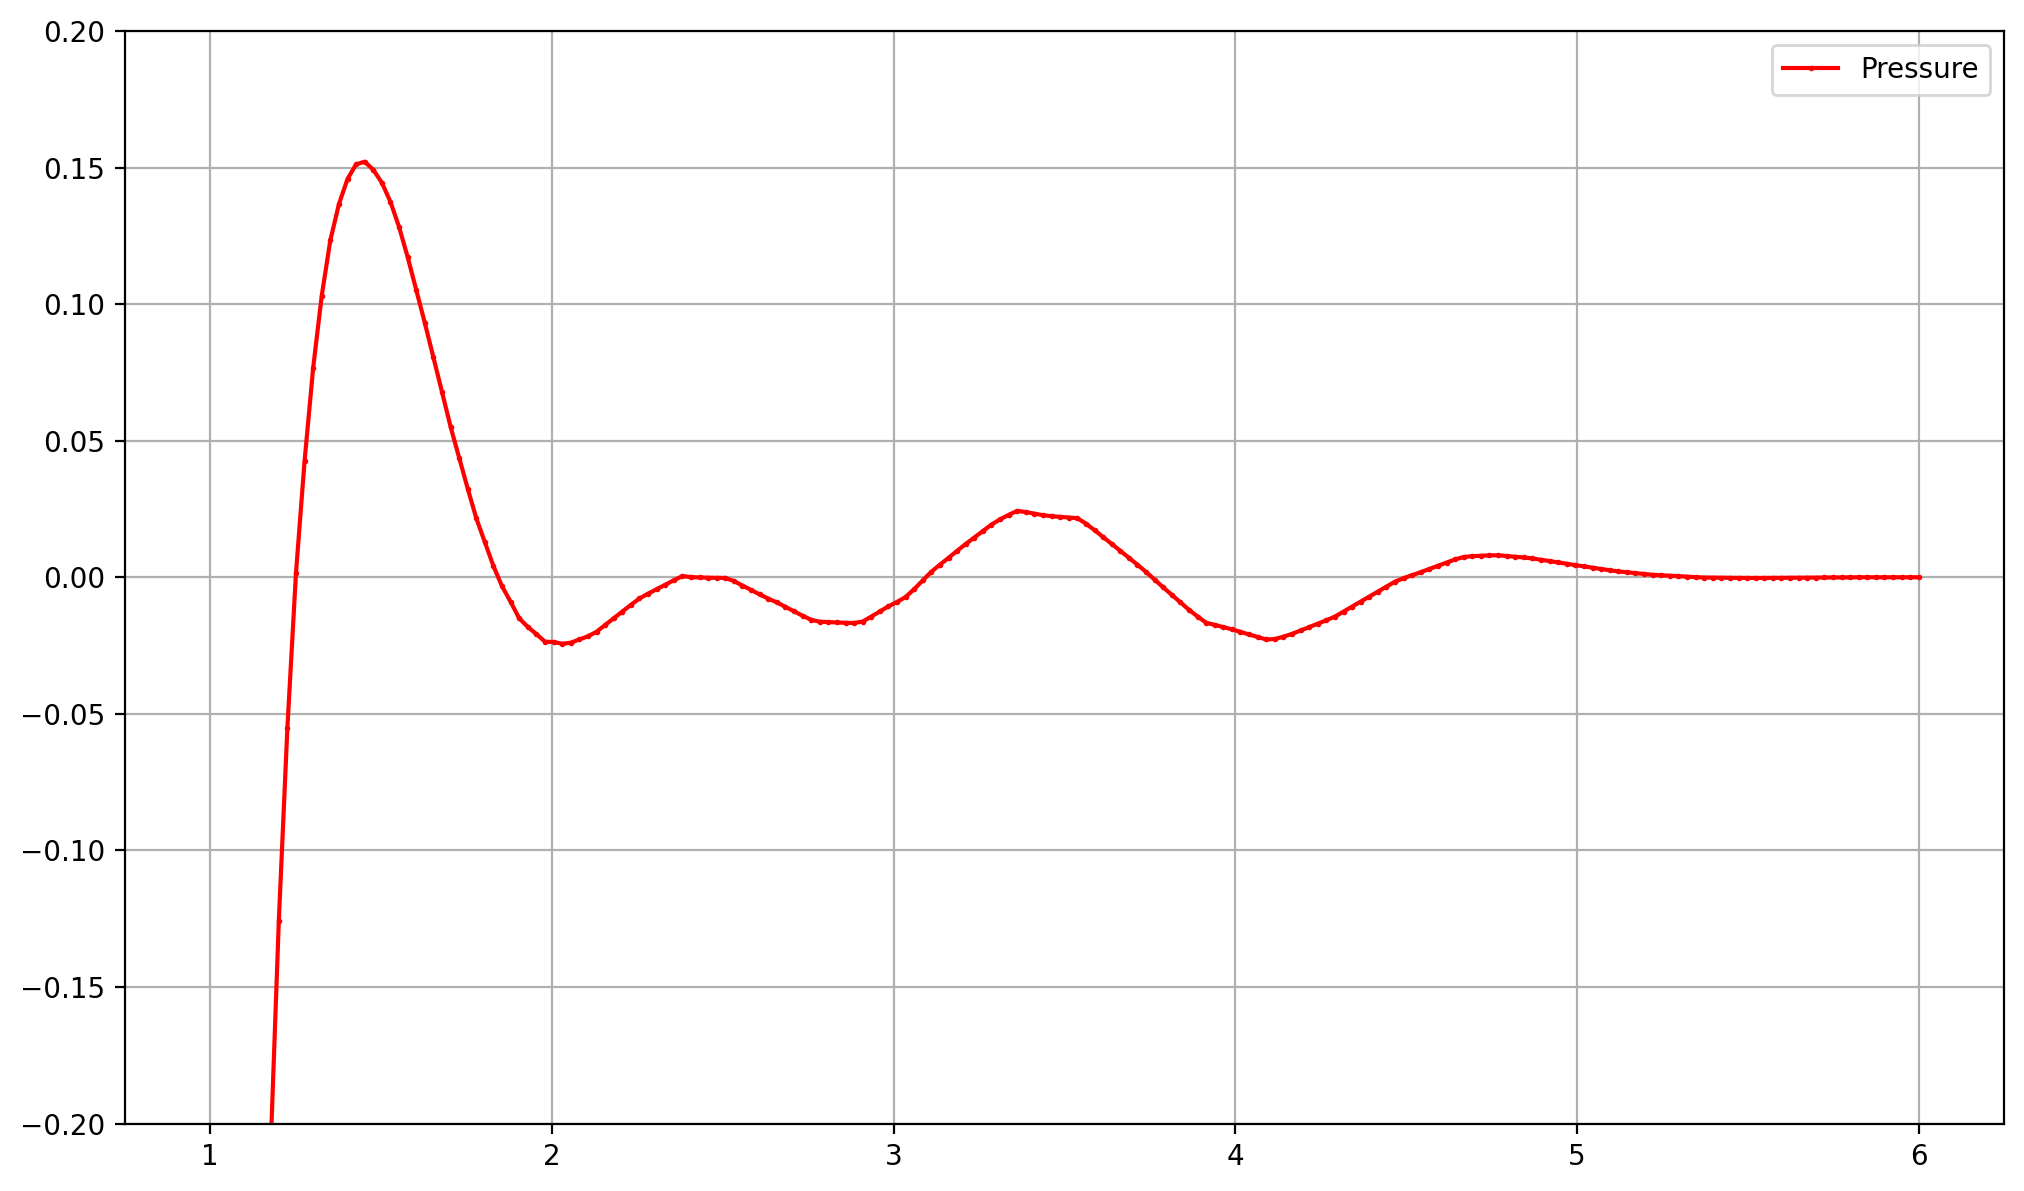

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(spatial_pts[:, 1], spatial_sol, label="Pressure", color="red", linestyle="-", marker="o", ms=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.xlim(left=2, right=6)
plt.ylim(top=0.2, bottom=-0.2)
# Show the plot
plt.show()

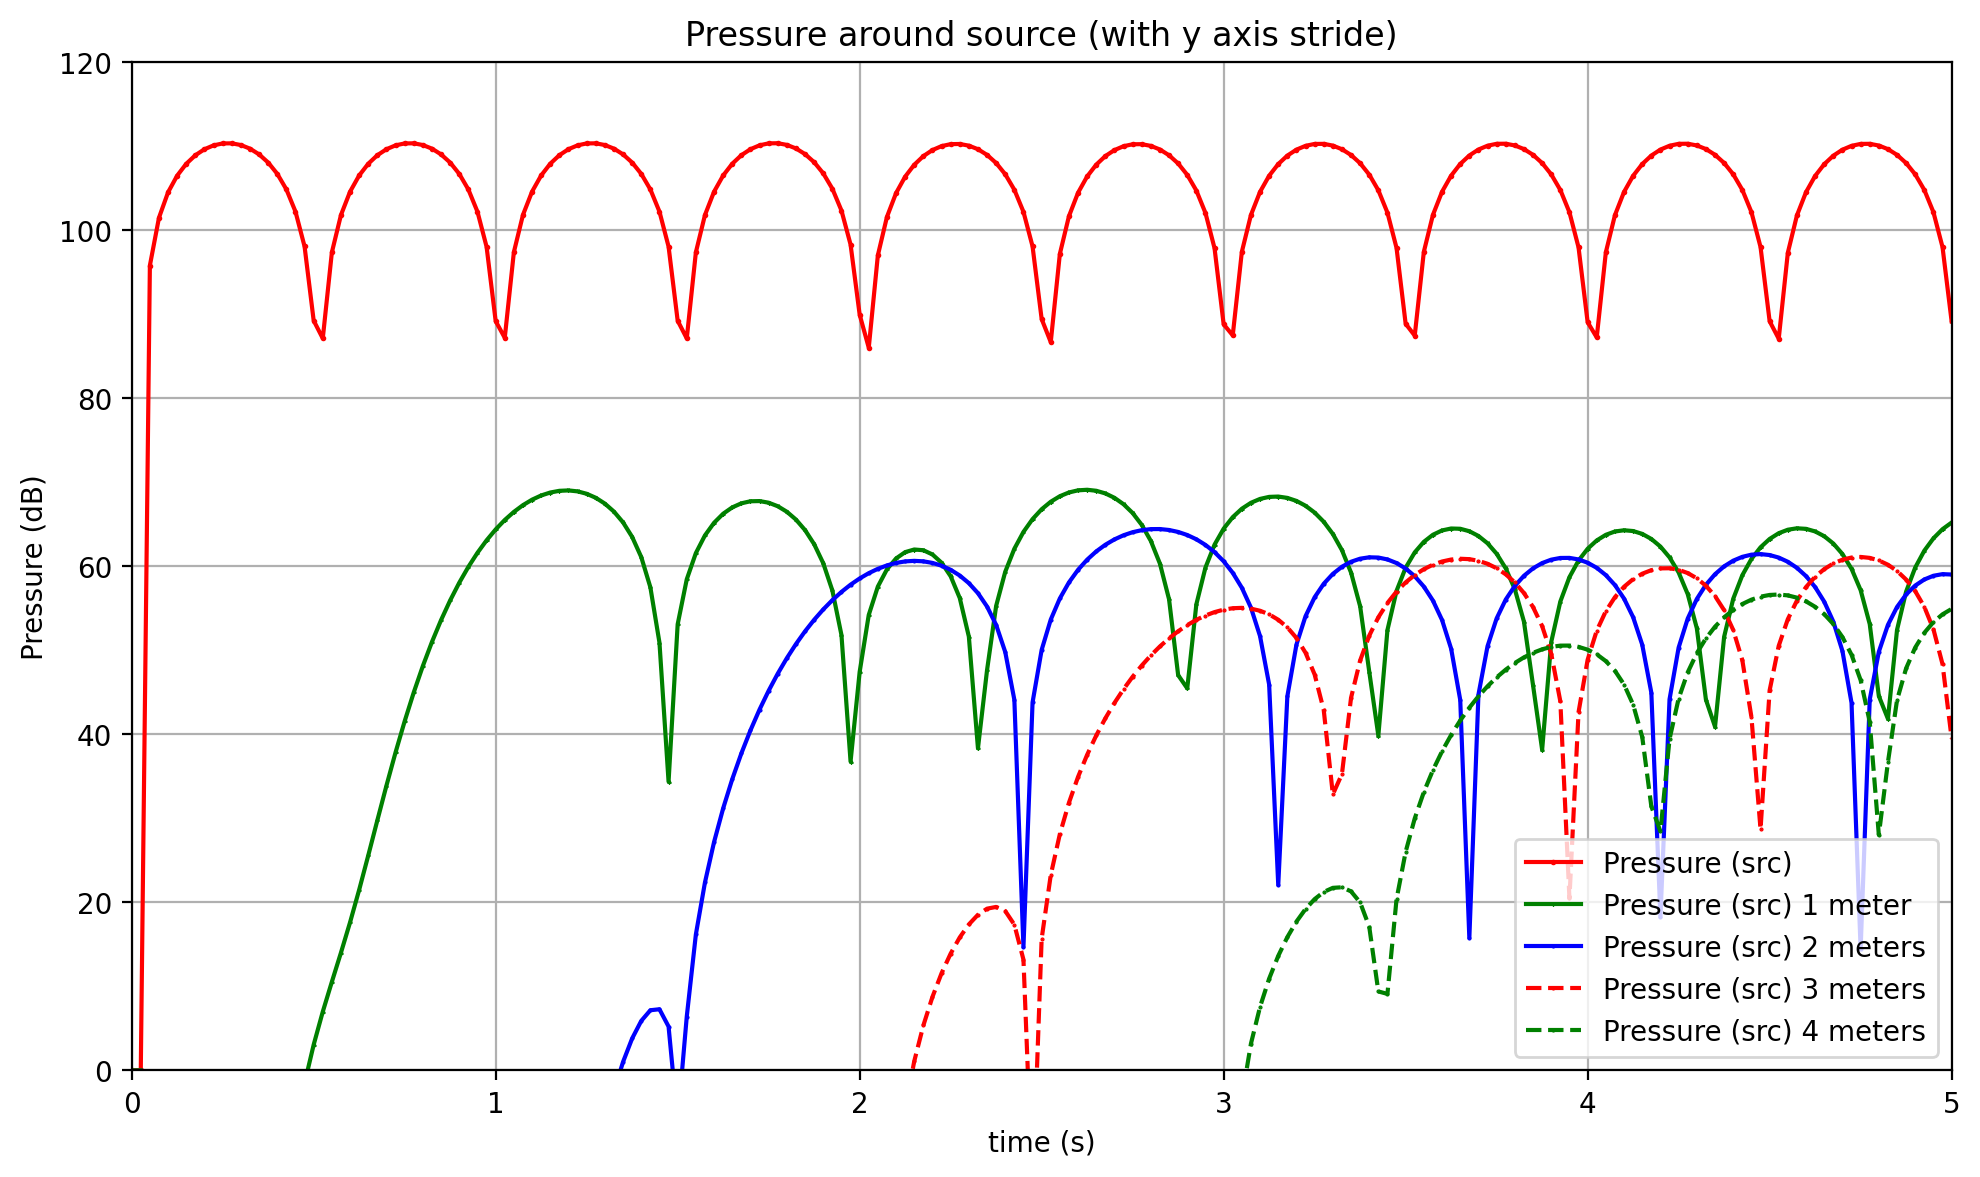

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time_mesh.mesh, ps[0], label="Pressure (src)", color="red", linestyle="-", marker="o", ms=1)
plt.plot(time_mesh.mesh, ps[1], label="Pressure (src) 1 meter", color="green", linestyle="-", marker="*", ms=1)
plt.plot(time_mesh.mesh, ps[2], label="Pressure (src) 2 meters", color="blue", linestyle="-", marker=".", ms=1)
plt.plot(time_mesh.mesh, ps[3], label="Pressure (src) 3 meters", color="red", linestyle="--", marker=".", ms=1)
plt.plot(time_mesh.mesh, ps[4], label="Pressure (src) 4 meters", color="green", linestyle="--", marker=".", ms=1)


# Add labels and title
plt.xlabel("time (s)")
plt.ylabel("Pressure (dB)")
plt.title("Pressure around source (with y axis stride)")
plt.xlim(left=0.0, right=5)
plt.ylim(top=120, bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()